# 🎧 Spotify User Churn Prediction – ML Task 2

A Churn Prediction System that identifies which customers are likely to stop using a service. This kind of model is crucial in industries like telecom, SaaS, and banking where retaining customers is more profitable than acquiring new ones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Load Spotify user churn dataset
df = pd.read_excel('/content/Spotify_data.xlsx')
df.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


## 🧹 Step 1: Data Cleaning & Feature Engineering

In [2]:
# Drop duplicates and fill missing with 'None' or appropriate value
df.drop_duplicates(inplace=True)
df.fillna('None', inplace=True)

# Encode categorical features using Label Encoding for simplicity
label_cols = df.columns
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Generate target label: churned = low engagement + no premium interest
df['Churn'] = np.where((df['premium_sub_willingness'] == encoders['premium_sub_willingness'].transform(['No'])[0]) &
                      (df['pod_lis_frequency'] == encoders['pod_lis_frequency'].transform(['Never'])[0]), 1, 0)
df['Churn'].value_counts()

,count
Churn,
0,420
1,99


## 🤖 Step 2: Train-Test Split

In [3]:
# Drop target leakage or unnecessary columns (like user ID if any)
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 🔍 Step 3: Train Models

In [4]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
log_preds = logreg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:12:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 📈 Step 4: Evaluate Models

In [5]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Results")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, log_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)


📊 Logistic Regression Results
[[79  5]
 [ 2 18]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        84
           1       0.78      0.90      0.84        20

    accuracy                           0.93       104
   macro avg       0.88      0.92      0.90       104
weighted avg       0.94      0.93      0.93       104


📊 Random Forest Results
[[83  1]
 [ 1 19]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.95      0.95      0.95        20

    accuracy                           0.98       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.98      0.98      0.98       104


📊 XGBoost Results
[[84  0]
 [ 0 20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        20

    accuracy                           1.00       

## 🔬 Step 5: Feature Importance

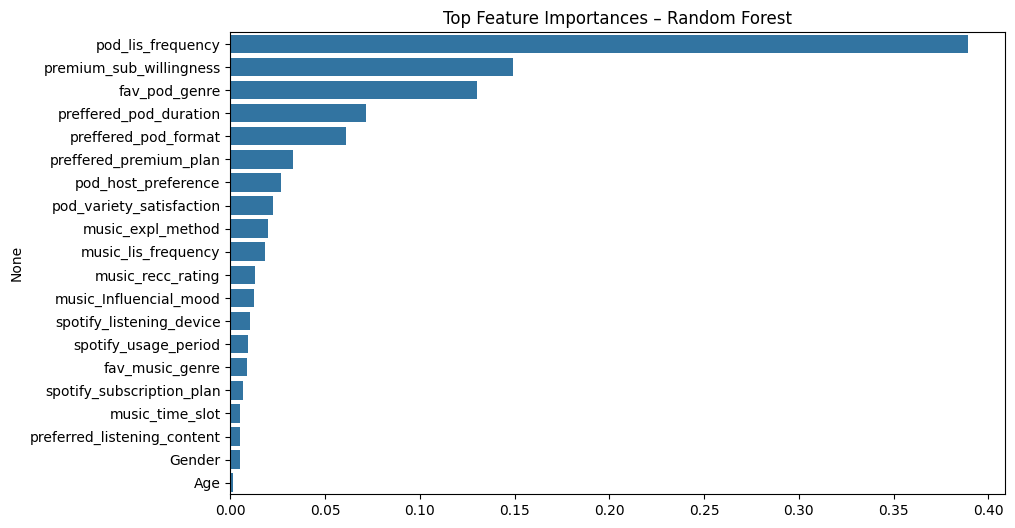

In [6]:
importances = rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title('Top Feature Importances – Random Forest')
plt.show()

## 🎯 Step 6: ROC Curve – XGBoost

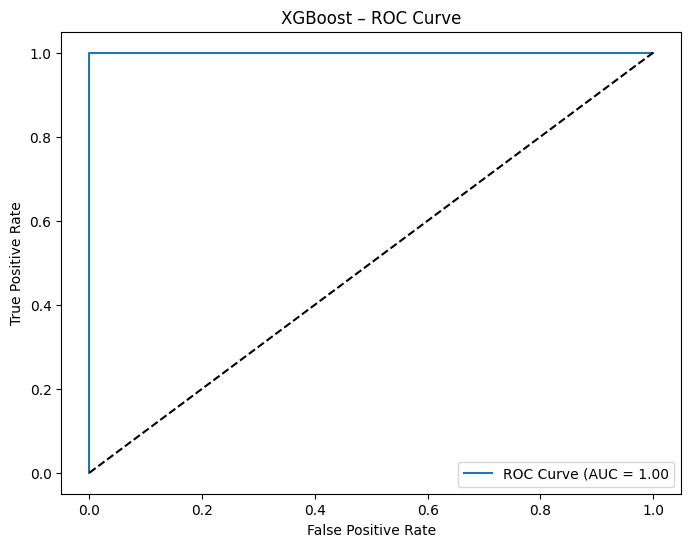

In [7]:
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost – ROC Curve')
plt.legend()
plt.show()

# 1. 📊 Churn Distribution Pie Chart / Count Plot

/tmp/ipython-input-9-3911697533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Churn', palette='Set2')


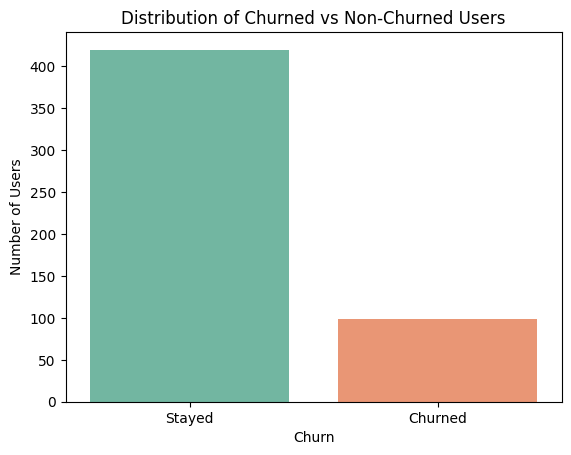

In [9]:
#Visualizes class balance (how many users churned vs. stayed)
sns.countplot(data=df, x='Churn', palette='Set2')
plt.title("Distribution of Churned vs Non-Churned Users")
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.ylabel("Number of Users")
plt.show()


# 2. 🎯 Churn Rate by Subscription Plan or Listening Frequency


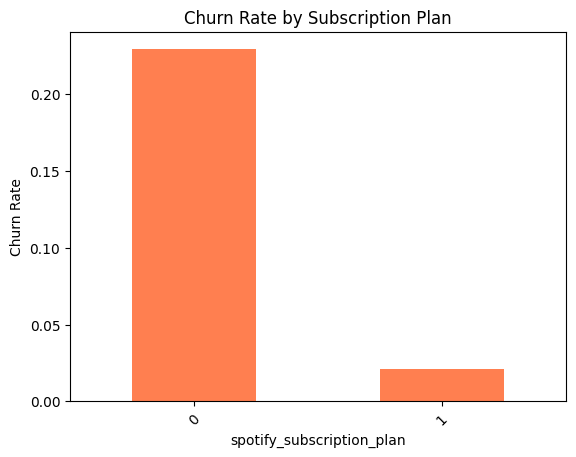

In [10]:
#Compare churn percentage across categories:
churn_by_plan = df.groupby('spotify_subscription_plan')['Churn'].mean().sort_values(ascending=False)
churn_by_plan.plot(kind='bar', color='coral')
plt.title("Churn Rate by Subscription Plan")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.show()


# 3. 🔍 Churn vs. Premium Willingness Heatmap


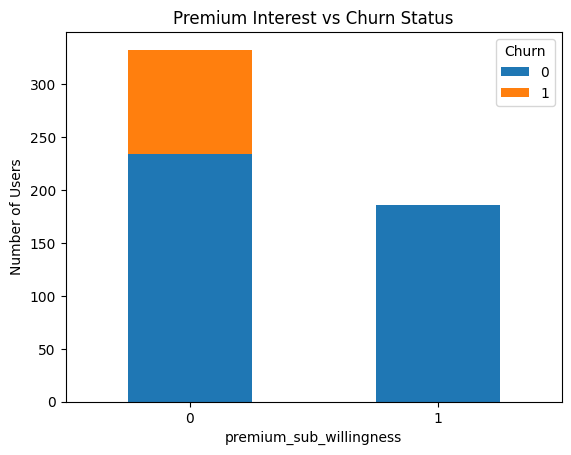

In [11]:
#Explore co-occurrence patterns between churn and premium intent.

pd.crosstab(df['premium_sub_willingness'], df['Churn']).plot(kind='bar', stacked=True)
plt.title("Premium Interest vs Churn Status")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.show()


# 4. 📈 Churn Probability Histogram (from XGBoost)


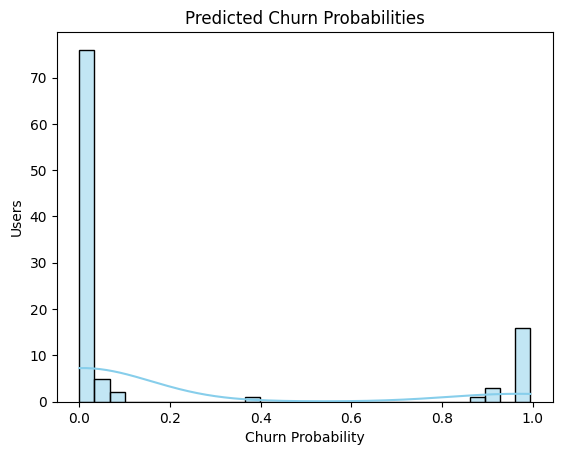

In [12]:
y_proba = xgb.predict_proba(X_test)[:, 1]
sns.histplot(y_proba, bins=30, kde=True, color='skyblue')
plt.title("Predicted Churn Probabilities")
plt.xlabel("Churn Probability")
plt.ylabel("Users")
plt.show()


# 5. 🧮 Correlation Heatmap


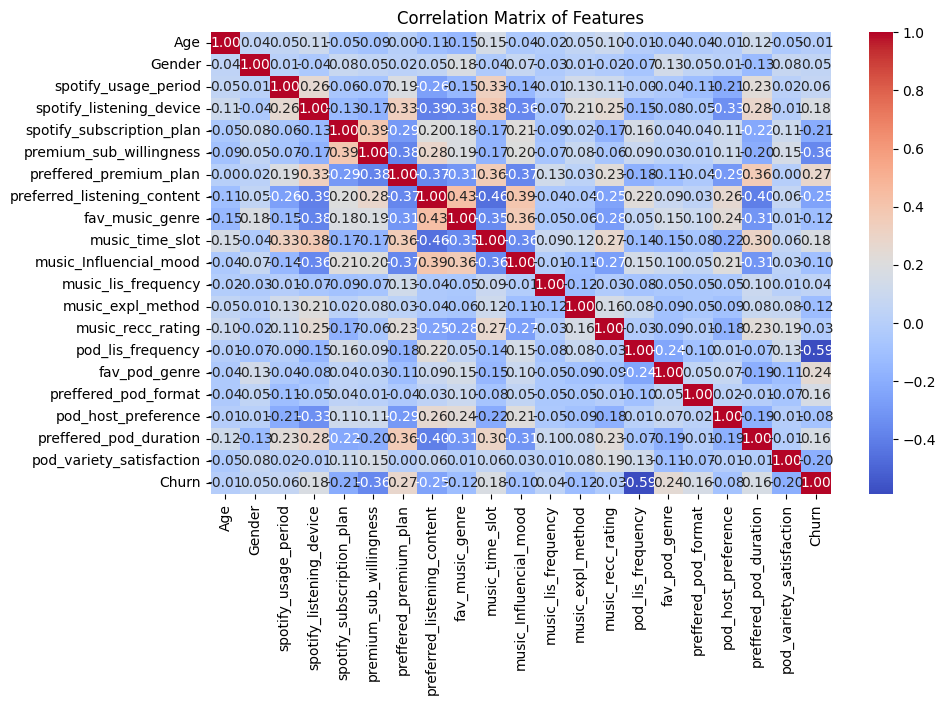

In [13]:
#To check how strong certain behaviors relate to churn

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()


# 6. 🗂️ Stacked Bar: Churn by Music Time Slot or Genre

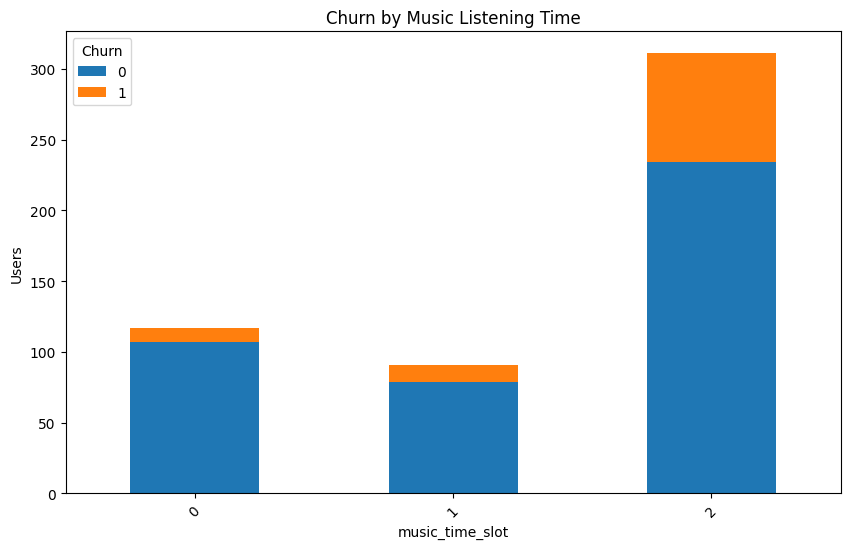

In [14]:
#Helps show behavioral insights across time slots or music taste
pd.crosstab(df['music_time_slot'], df['Churn']).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Churn by Music Listening Time")
plt.ylabel("Users")
plt.xticks(rotation=45)
plt.show()
